In [ ]:
# --- Imports and Setup ---
import torch
import torch.nn as nn
import numpy as np
import sys
import os
import matplotlib.pyplot as plt

# Add the src directory to the Python path to import our custom modules
sys.path.append(os.path.abspath(os.path.join('..', 'src')))
import config
from model import TransformerAutoencoder
from data_loader import load_and_preprocess_data

In [ ]:
# --- Load a Sample of the Preprocessed Data ---
# We load the full preprocessed data and take a small sample for quick prototyping.
print("Loading preprocessed data...")
# Define the path relative to the project root, which is one level up from the notebooks directory.
root_processed_data_path = os.path.join('..', config.PROCESSED_DATA_DIR, 'X_benign_sequences.npy')
try:
    X_benign_sequences = np.load(root_processed_data_path)
    print(f"Data loaded successfully from '{root_processed_data_path}'. Shape: {X_benign_sequences.shape}")
except FileNotFoundError:
    print(f"Processed data not found at '{root_processed_data_path}'.")
    print("Please ensure you have run `python src/data_loader.py` from the project's root directory first.")
    X_benign_sequences = None

# Use a small sample for prototyping
if X_benign_sequences is not None:
    X_sample = X_benign_sequences[:1000]
    X_sample_tensor = torch.tensor(X_sample, dtype=torch.float32).to(config.DEVICE)

Loading preprocessed data...
Data loaded successfully from '../data/processed/X_benign_sequences.npy'. Shape: (56326, 100, 84)


In [ ]:
# --- Initialize Model and Criterion ---
# This cell initializes the model with the parameters from the config file.
if X_benign_sequences is not None:
    # Dynamically get the number of input features from the loaded data
    # to prevent the shape mismatch runtime error.
    num_features = X_benign_sequences.shape[2]
    print(f"Dynamically detected {num_features} features from the loaded data.")
    
    model = TransformerAutoencoder(
        input_features=num_features, # Use the actual feature count from the data
        model_dim=config.MODEL_DIM,
        num_heads=config.NUM_HEADS,
        num_encoder_layers=config.NUM_ENCODER_LAYERS,
        dim_feedforward=config.DIM_FEEDFORWARD,
        dropout=config.DROPOUT
    ).to(config.DEVICE)
    
    optimizer = torch.optim.Adam(model.parameters(), lr=config.LEARNING_RATE)
    criterion = nn.MSELoss()
    
    print("Model initialized successfully with the correct input feature dimension.")
    # print(model) # Uncomment to see the model architecture

Dynamically detected 84 features from the loaded data.
Model initialized successfully with the correct input feature dimension.


In [ ]:
# --- Prototyping Training Loop ---
# A simplified training loop to run a few epochs on the sample data to ensure the model trains.
if X_benign_sequences is not None:
    print("\nStarting prototype training...")
    # Increased epochs to allow the model more time to learn
    num_prototype_epochs = 30 
    loss_history = []
    
    for epoch in range(num_prototype_epochs):
        model.train()
        
        batch = X_sample_tensor
        
        # Forward pass
        reconstructions = model(batch)
        loss = criterion(reconstructions, batch)
        
        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        loss_history.append(loss.item())
        if (epoch + 1) % 5 == 0:
            print(f"Epoch [{epoch+1}/{num_prototype_epochs}], Loss: {loss.item():.6f}")


Starting prototype training...
Epoch [5/30], Loss: 1.066732
Epoch [10/30], Loss: 0.955981
Epoch [15/30], Loss: 0.900139
Epoch [20/30], Loss: 0.869968
Epoch [25/30], Loss: 0.846177
Epoch [30/30], Loss: 0.818560


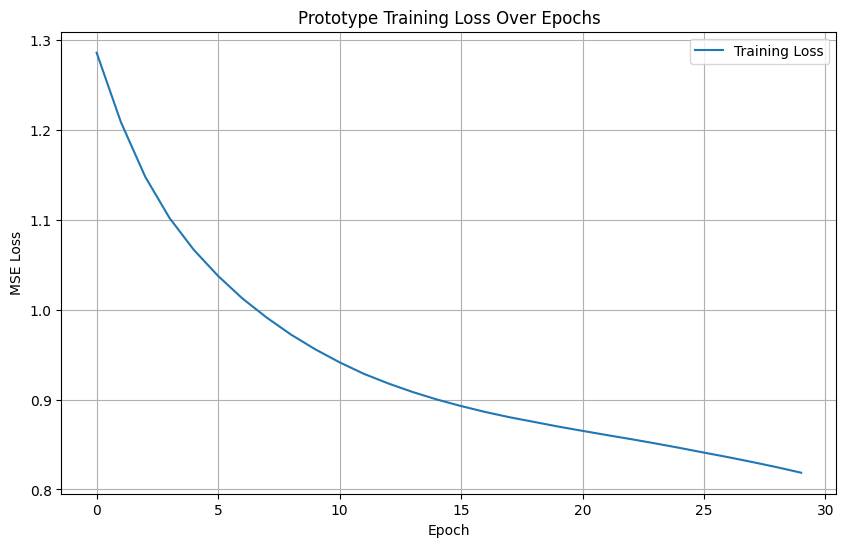

In [ ]:
# --- Plot Training Loss ---
# This new cell visualizes the loss to confirm the model is learning.
# A downward trend indicates that the model is improving its reconstructions.
if 'loss_history' in locals() and loss_history:
    plt.figure(figsize=(10, 6))
    plt.plot(loss_history, label='Training Loss')
    plt.title('Prototype Training Loss Over Epochs')
    plt.xlabel('Epoch')
    plt.ylabel('MSE Loss')
    plt.legend()
    plt.grid(True)
    plt.show()

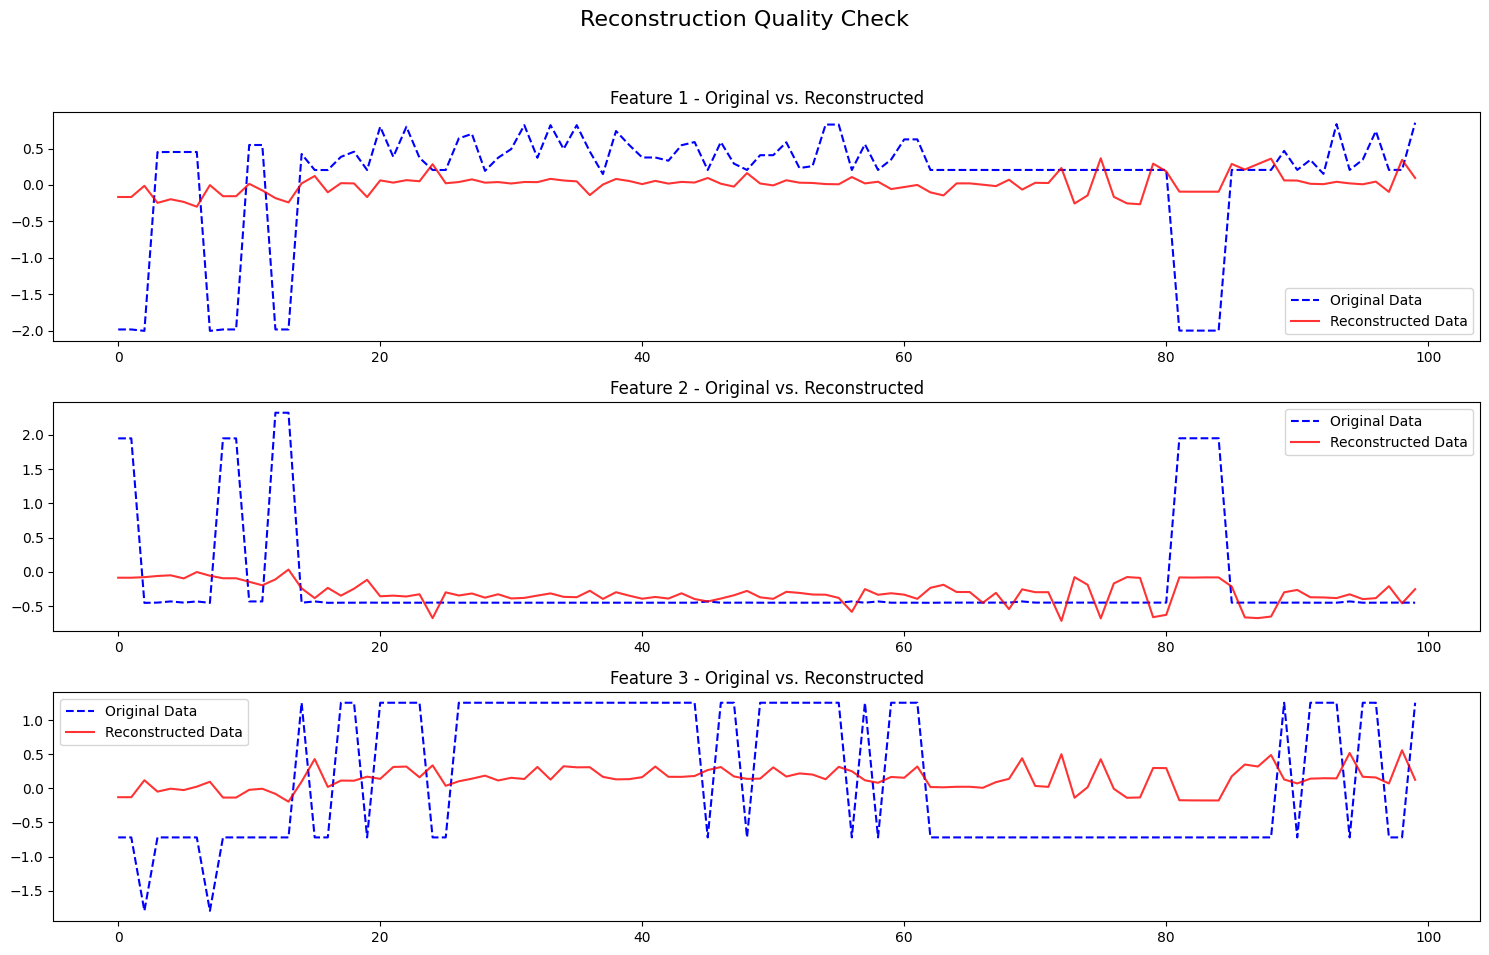


Mean Squared Error on REAL data sequence: 0.929360
Mean Squared Error on RANDOM noise sequence: 1.098881

✅ The model reconstructs real data better than random noise, which is a good sign!


In [ ]:
# --- Test Reconstruction on a Single Sequence ---
# This cell visualizes the original vs. reconstructed values for a few features of a single sequence.
if X_benign_sequences is not None:
    model.eval()
    with torch.no_grad():
        # Get a single sequence from our sample
        test_sequence = X_sample_tensor[0].unsqueeze(0)
        reconstructed_sequence = model(test_sequence)
        
        # Create a random noise sequence for comparison
        noise_sequence = torch.randn_like(test_sequence)
        reconstructed_noise = model(noise_sequence)
        
        # Move to CPU and convert to numpy for plotting
        original = test_sequence.squeeze(0).cpu().numpy()
        reconstructed = reconstructed_sequence.squeeze(0).cpu().numpy()
        
    # Plot the first 3 features for comparison
    plt.figure(figsize=(15, 10))
    plt.suptitle('Reconstruction Quality Check', fontsize=16)
    for i in range(3):
        plt.subplot(3, 1, i + 1)
        plt.plot(original[:, i], label='Original Data', color='blue', linestyle='--')
        plt.plot(reconstructed[:, i], label='Reconstructed Data', color='red', alpha=0.8)
        plt.title(f'Feature {i+1} - Original vs. Reconstructed')
        plt.legend()
    
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()
    
    # Calculate reconstruction error for the real sequence and the noise
    real_error = nn.functional.mse_loss(test_sequence, reconstructed_sequence).item()
    noise_error = nn.functional.mse_loss(noise_sequence, reconstructed_noise).item()
    
    print(f"\nMean Squared Error on REAL data sequence: {real_error:.6f}")
    print(f"Mean Squared Error on RANDOM noise sequence: {noise_error:.6f}")
    
    if real_error < noise_error:
        print("\n✅ The model reconstructs real data better than random noise, which is a good sign!")
    else:
        print("\n⚠️ The model does not reconstruct real data better than random noise. Consider training for more epochs or tuning hyperparameters.")

